<a href="https://colab.research.google.com/github/esuda/mineiracao_dados_complexos/blob/master/TCC_MDC_Fer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Plant Pathology Classification

# Setup


In [1]:
import numpy as np
import pandas as pd
%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
import os
import warnings
warnings.filterwarnings('ignore')
import random
from PIL import Image
from matplotlib import image

import tensorflow as tf
!pip install tensorflow_addons
import tensorflow_addons as tfa
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Activation,Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.metrics import Metric
from tensorflow.python.keras.utils import metrics_utils
from tensorflow.python.ops import init_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.keras.utils.generic_utils import to_list
from tensorflow.keras.metrics import Recall, SpecificityAtSensitivity
from tensorflow.python.ops import math_ops
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import (
    Input, Conv2D, Dense, Flatten, Dropout,
    GlobalMaxPooling2D, MaxPooling2D, BatchNormalization, MaxPool2D
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau
from tensorflow.keras.utils import plot_model
from keras.layers.merge import concatenate

from sklearn.metrics import (
    confusion_matrix, classification_report,
    balanced_accuracy_score
)

from google.colab import files
from google.colab import drive

     |████████████████████████████████| 1.1 MB 5.1 MB/s 


# 01 - Carregando das imagens

In [2]:
# Necessario usar chave do kaggle nesse pedaço de codigo
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"shigerufw","key":"3927570408f8f6b855fbddfd3df1d028"}'}

In [3]:
! pip install kaggle==1.5.6
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

     |████████████████████████████████| 58 kB 3.4 MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.6-py3-none-any.whl size=72857 sha256=5c85f5c10cfdbe22131108ef22e18d131883b6be1274a64411650e589f490b6a
  Stored in directory: /root/.cache/pip/wheels/aa/e7/e7/eb3c3d514c33294d77ddd5a856bdd58dc9c1fabbed59a02a2b
Successfully built kaggle
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.12
    Uninstalling kaggle-1.5.12:
      Successfully uninstalled kaggle-1.5.12


In [4]:
! mkdir dataset

In [8]:
! kaggle competitions download -c plant-pathology-2021-fgvc8 -p '/content/dataset'


100% 14.9G/14.9G [02:41<00:00, 179MB/s]
100% 14.9G/14.9G [02:41<00:00, 98.9MB/s]


In [9]:
! unzip '/content/dataset/plant-pathology-2021-fgvc8.zip' -d '/content/dataset'

A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: /content/dataset/train_images/e00c97b2de4749ce.jpg  
  inflating: /content/dataset/train_images/e00df890cfe62736.jpg  
  inflating: /content/dataset/train_images/e00ed0bf43a87f25.jpg  
  inflating: /content/dataset/train_images/e00f759d65d52887.jpg  
  inflating: /content/dataset/train_images/e00f934d9e50ad5b.jpg  
  inflating: /content/dataset/train_images/e00fce341cb63da5.jpg  
  inflating: /content/dataset/train_images/e010c7c35ecf3d1c.jpg  
  inflating: /content/dataset/train_images/e01112939f783fec.jpg  
  inflating: /content/dataset/train_images/e01592da4d71b8be.jpg  
  inflating: /content/dataset/train_images/e0189acaf8cf80fd.jpg  
  inflating: /content/dataset/train_images/e0189e4999bdd0fa.jpg  
  inflating: /content/dataset/train_images/e01ae16d4a759cb5.jpg  
  inflating: /content/dataset/train_images/e01dc39ccb2b4ccb.jpg  
  inflating: /content/dataset/train_images/e01e42d90c66f3f3.jpg  
  inflating: /con

In [10]:
train_image_path = './dataset/train_images'
test_image_path = './dataset/test_images'
train_df_path = './dataset/train.csv'
test_df_path = './dataset/sample_submission.csv'

In [11]:
df_train = pd.read_csv(train_df_path)
df_test= pd.read_csv(test_df_path)

In [9]:

df_test

image   labels
0  85f8cb619c66b863.jpg  healthy
1  ad8770db05586b59.jpg  healthy
2  c7b03e718489f3ca.jpg  healthy

# Carregamento de Dados



## Recarregamento de Dados - Importar csv

In [12]:
drive.mount('/content/drive')

Mounted at /content/drive


In [13]:
del(df_train, df_test)

In [14]:
df_train = pd.read_csv('./drive/MyDrive/TFG-unicamp/df_train_exif.csv')
df_test = pd.read_csv('./drive/MyDrive/TFG-unicamp/df_test_exif.csv')

In [15]:
df_train

image                           labels  ... mode qtd
0      800113bb65efe69e.jpg                          healthy  ...  RGB   1
1      8002cb321f8bfcdf.jpg  scab frog_eye_leaf_spot complex  ...  RGB   1
2      80070f7fb5e2ccaa.jpg                             scab  ...  RGB   1
3      80077517781fb94f.jpg                             scab  ...  RGB   1
4      800cbf0ff87721f8.jpg                          complex  ...  RGB   1
...                     ...                              ...  ...  ...  ..
18627  fffb900a92289a33.jpg                          healthy  ...  RGB   1
18628  fffc488fa4c0e80c.jpg                             scab  ...  RGB   1
18629  fffc94e092a59086.jpg                             rust  ...  RGB   1
18630  fffe105cf6808292.jpg          scab frog_eye_leaf_spot  ...  RGB   1
18631  fffe472a0001bd25.jpg                          healthy  ...  RGB   1

[18632 rows x 15 columns]

## Carregamento de Dados - Reading EXIF from images

In [16]:
import hashlib
from tqdm.notebook import tqdm
import hashlib

In [17]:
df_test

image   labels      dataset  ... width  format  mode
0  85f8cb619c66b863.jpg  healthy  test_images  ...  3456    JPEG   RGB
1  ad8770db05586b59.jpg  healthy  test_images  ...  2672    JPEG   RGB
2  c7b03e718489f3ca.jpg  healthy  test_images  ...  2672    JPEG   RGB

[3 rows x 14 columns]

In [ ]:
def ret_calculate_hash(img_matx):
    md5 = hashlib.md5()
    md5.update(np.array(img_matx).tostring())
    
    return md5.hexdigest()

In [ ]:
def ret_dict_meta(image_name, path = TRAIN_PATH):
    img_o = Image.open(path+image_name)
    extrema = img_o.getextrema()
    meta = {
    'image': image_name,
    'dataset': path.split('/')[-2],
    'hash':  ret_calculate_hash(img_o),
    'r_min': extrema[0][0],
    'r_max': extrema[0][1],
    'g_min': extrema[1][0],
    'g_max': extrema[1][1],
    'b_min': extrema[2][0],
    'b_max': extrema[2][1],
    'height': img_o.size[0],
    'width': img_o.size[1],
    'format': img_o.format,
    'mode': img_o.mode
    }
    return meta

In [ ]:
ret_dict_meta(df_test['image'][0], path = TEST_PATH)

{'b_max': 255,
 'b_min': 0,
 'dataset': 'test_images',
 'format': 'JPEG',
 'g_max': 255,
 'g_min': 18,
 'hash': '3e079321d303e8f8b6364d77d3b14d41',
 'height': 5184,
 'image': '85f8cb619c66b863.jpg',
 'mode': 'RGB',
 'r_max': 255,
 'r_min': 11,
 'width': 3456}

In [ ]:
lst_test = []

for i, image_name in enumerate(tqdm(df_test['image'].values, total = df_test.shape[0])):
  #print(image_name)
  lst_test.append(ret_dict_meta(image_name, path = TEST_PATH))

  0%|          | 0/3 [00:00<?, ?it/s]

In [ ]:
df_test_exif = pd.DataFrame(lst_test)
#df_test_exif

In [ ]:
df_test = pd.merge(df_test,df_test_exif, how='left', on = 'image')
df_test

image   labels      dataset  ... width  format  mode
0  85f8cb619c66b863.jpg  healthy  test_images  ...  3456    JPEG   RGB
1  ad8770db05586b59.jpg  healthy  test_images  ...  2672    JPEG   RGB
2  c7b03e718489f3ca.jpg  healthy  test_images  ...  2672    JPEG   RGB

[3 rows x 14 columns]

In [ ]:
lst_train = []

for i, image_name in enumerate(tqdm(df_train['image'].values, total = df_train.shape[0])):
  #print(image_name)
  lst_train.append(ret_dict_meta(image_name, path = TRAIN_PATH))

  0%|          | 0/18632 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
df_train_exif = pd.DataFrame(lst_train)
#df_train_exif

In [ ]:
df_train = pd.merge(df_train,df_train_exif, how='left', on = 'image')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
df_test.to_csv('./drive/MyDrive/TFG-unicamp/df_test_exif.csv', index = False)
df_train.to_csv('./drive/MyDrive/TFG-unicamp/df_train_exif.csv', index = False)

# Análise exploratória dos dados

## 03.01 - Análise das labels



In [ ]:
df_train.labels.value_counts()


scab                               4826
healthy                            4624
frog_eye_leaf_spot                 3181
rust                               1860
complex                            1602
powdery_mildew                     1184
scab frog_eye_leaf_spot             686
scab frog_eye_leaf_spot complex     200
frog_eye_leaf_spot complex          165
rust frog_eye_leaf_spot             120
rust complex                         97
powdery_mildew complex               87
Name: labels, dtype: int64

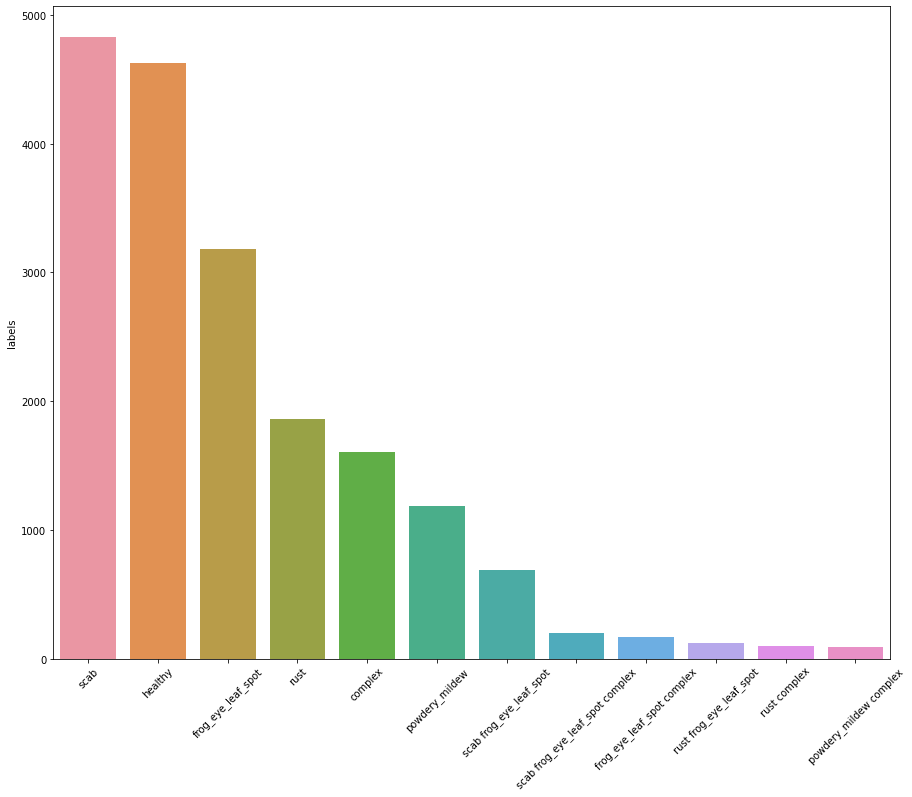

In [ ]:
plt.figure(figsize=(15,12))
labels = sns.barplot(df_train.labels.value_counts().index,df_train.labels.value_counts())
for item in labels.get_xticklabels():
    item.set_rotation(45)

In [ ]:
df_train_count = df_train.groupby('labels').sum()['qtd'].reset_index()

In [ ]:
df_train_mean = df_train.groupby('labels').mean()[['r_min', 'r_max', 'g_min', 'g_max', 'b_min', 'b_max', 'height', 'width',]].reset_index()

In [ ]:
df_train_status = pd.merge(df_train_mean, df_train_count, how = 'left', on = 'labels')
df_train_status.sort_values('qtd', ascending= False)
df_train_status.index = df_train_status['labels']
df_train_status = df_train_status[['r_min', 'r_max', 'g_min', 'g_max', 'b_min', 
                                   'b_max','height', 'width', 'qtd']]
df_train_status = df_train_status

r_min       r_max  ...        width   qtd
labels                                                  ...                   
complex                          23.636536  254.742731  ...  2658.331226  1582
frog_eye_leaf_spot               15.950644  254.047784  ...  2672.618673  3181
frog_eye_leaf_spot complex       28.515152  254.739394  ...  2673.987879   165
healthy                          16.139057  253.006488  ...  2694.069204  4624
powdery_mildew                   18.960304  251.369932  ...  2675.324324  1184
powdery_mildew complex           19.471264  254.505747  ...  2754.942529    87
rust                             14.799782  253.917621  ...  2394.378614  1833
rust complex                     20.153846  254.406593  ...  2651.164835    91
rust frog_eye_leaf_spot          22.941176  254.235294  ...  2423.327731   119
scab                             14.552424  251.466432  ...  2680.495649  4826
scab frog_eye_leaf_spot          21.059767  254.504373  ...  2667.918367   686
scab frog_eye_leaf_spot complex  26.905000  254.720000  ...  2680.200000   200

[12 rows x 9 columns]

### Plottando Images

In [ ]:
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
from plotly.subplots import make_subplots

In [ ]:
TRAIN_PATH = './dataset/train_images/'
TEST_PATH = './dataset/test_images/'

In [ ]:
def plot_image(image_name, path = TRAIN_PATH, figsize = (410,272)):
  if path == TRAIN_PATH:
    label = df_train[df_train['image'] == image_name]['labels'].item()
    
  elif path == TEST_PATH:
    label = df_test[df_test['image'] == image_name]['labels'].item()
    
  
  fig = px.imshow(cv2.resize(ret_img(image_name, path), figsize))
  fig.update_layout(
    title="{} - {}".format(label, image_name)
    )

  
  
  fig.show()


### **Plotar Exemplos ou Amostra de Exemplos** 

https://www.kaggle.com/praveengovi/plant-pathology-detail-eda-pytorch

na parte:

"Let see the Plant pathology Images"

In [ ]:
len(df_train['labels'].unique())

12

In [ ]:
def ret_img(image_name, path = TRAIN_PATH):
  img = image.imread(path + image_name)
  return img

In [ ]:
plot_image(df_train['image'][1], path = TRAIN_PATH, figsize = (410,272))

## 03.02 - Análise do dataframe

### Duplicatas

In [ ]:
df_train['image'].value_counts()

e595251f394a98ae.jpg    1
d08ec37ee1642376.jpg    1
976e1ec60dcb023d.jpg    1
d1bc99ca2f01e61b.jpg    1
defe7e9568880138.jpg    1
                       ..
88e21dc2dedcc69c.jpg    1
f8d4c9c2051f24fd.jpg    1
9235e2d28b7aed48.jpg    1
b235de10677b58b0.jpg    1
a501cbd8bd497366.jpg    1
Name: image, Length: 18632, dtype: int64

In [ ]:
df_count_hash = pd.DataFrame(df_train['hash'].value_counts()).reset_index()
df_count_hash = df_count_hash.rename(columns = {'hash':'qtd'})
df_count_hash = df_count_hash.rename(columns = {'index':'hash'})
df_count_hash

hash  qtd
0      56c923f76846802e54317cf3163d26b4    2
1      ec8e62e066338b14b1bb6ad3e799a66b    2
2      648689a1ad9d7a40ac1746f2eebf2c3d    2
3      28828edc5c2b601fdee0b35c20272190    2
4      22f4ce30e3a744c483d8e70e48a43387    2
...                                 ...  ...
18600  0e785a999b3fc519bc7e7f1e2a56cc9b    1
18601  09cb1a50131710a38c65993b56bf10c4    1
18602  e046edb9d1609dfbc17e9692c83c717c    1
18603  51aab6bc933b52d3bbf4741a24d9b130    1
18604  eaf008dd49b8971b7c393ce4c1ddaa41    1

[18605 rows x 2 columns]

In [ ]:
df_train = pd.merge(df_train, df_count_hash, how = 'left' , on = ['hash'])

In [ ]:
df_dup = df_train[df_train['qtd'] == 2]
df_dup

image                   labels  ... mode qtd
410    82ba3e933947b097.jpg             rust complex  ...  RGB   2
630    848d9f9e82d18e5e.jpg                     rust  ...  RGB   2
786    85897ea7f064b26a.jpg                  complex  ...  RGB   2
995    86f963a16e70345e.jpg             rust complex  ...  RGB   2
1567   8c0731fff680c51e.jpg                     rust  ...  RGB   2
1901   8f5263c61a8cdbe2.jpg                     rust  ...  RGB   2
2045   90a5341f227ce5f9.jpg                  complex  ...  RGB   2
2124   90f99ee1c1132bb6.jpg                     rust  ...  RGB   2
2528   949b6595a5b8ca3c.jpg                  complex  ...  RGB   2
2557   94b42695f24dad36.jpg                  complex  ...  RGB   2
2576   94c83b2d5fad6924.jpg                  complex  ...  RGB   2
2886   965295a64a97859f.jpg                     rust  ...  RGB   2
3363   9ada65c5b0cc9a3c.jpg                  complex  ...  RGB   2
3789   9fad869f21b5b240.jpg             rust complex  ...  RGB   2
3806   9fc321ce60a69f0b.jpg                     rust  ...  RGB   2
4410   a3bb604d8a55995d.jpg                  complex  ...  RGB   2
5078   a7e613159fb22859.jpg             rust complex  ...  RGB   2
5442   a9b2e4b09297bc2b.jpg                     rust  ...  RGB   2
5529   aa0e969518e15d3f.jpg                     rust  ...  RGB   2
6425   ae5074cfc9183763.jpg                  complex  ...  RGB   2
7703   b5ec52491e3349ce.jpg                     rust  ...  RGB   2
7923   b7b0edd58a858217.jpg                     rust  ...  RGB   2
8236   ba99260ef46b18cb.jpg                  complex  ...  RGB   2
8303   bb1891fa8c61e663.jpg                  complex  ...  RGB   2
8586   bd8088cdad5f65e0.jpg                     rust  ...  RGB   2
9361   c1753cad2f31d492.jpg                     rust  ...  RGB   2
9411   c1a56069de75b899.jpg                  complex  ...  RGB   2
10080  c5aff2e545d0a129.jpg                  complex  ...  RGB   2
10663  c9d63696629107ed.jpg                  complex  ...  RGB   2
10731  ca782c131f5ce0fc.jpg                  complex  ...  RGB   2
11165  cdf892b5b4865859.jpg                     rust  ...  RGB   2
11588  d0c766bc38e1978c.jpg                  complex  ...  RGB   2
11752  d1dec0973c2cf4a1.jpg  rust frog_eye_leaf_spot  ...  RGB   2
11761  d1f01e8d8a73274d.jpg             rust complex  ...  RGB   2
11782  d2266ac99461e9db.jpg             rust complex  ...  RGB   2
11907  d2d9c2bca7a72458.jpg                     rust  ...  RGB   2
11979  d3945c098edc9dd1.jpg                     rust  ...  RGB   2
12414  d64460a3b19f1cfc.jpg                  complex  ...  RGB   2
12617  d7ec32d72c84dc18.jpg                     rust  ...  RGB   2
13101  dbee22785d9285c4.jpg                     rust  ...  RGB   2
13436  dea33c5c0347aa4d.jpg                  complex  ...  RGB   2
13542  df90901ccb664de6.jpg                  complex  ...  RGB   2
14409  e51690d8ad307dcb.jpg                  complex  ...  RGB   2
14584  e5f27342ce1cb9a0.jpg                     rust  ...  RGB   2
14700  e7ecc583d571d202.jpg                     rust  ...  RGB   2
14737  e83f715e56462a31.jpg                     rust  ...  RGB   2
15051  e9e8ad35c5871d06.jpg                     rust  ...  RGB   2
15408  ec83c7c04a1e9db9.jpg                     rust  ...  RGB   2
15654  eec64e8cf1c8d0c6.jpg                     rust  ...  RGB   2
16346  f2c798246a0a9bdd.jpg                     rust  ...  RGB   2
16416  f3dc17a2b20d48ec.jpg                     rust  ...  RGB   2
16638  f4cba4a7294d6585.jpg                     rust  ...  RGB   2
17113  f7d233d11aa8496c.jpg                     rust  ...  RGB   2
17384  f90738a0d2f2c1db.jpg                  complex  ...  RGB   2

[54 rows x 15 columns]

### Plottando duplicates

In [ ]:
df_train[df_train['hash'] == 'c5d423bf75d28f32a79100850e4587c1'].reset_index(drop = True)['image'].loc[0]

'b7b0edd58a858217.jpg'

In [ ]:
def plot_duplicates(hash_plot, path = TRAIN_PATH):
  df_plot = df_train[df_train['hash'] == hash_plot].reset_index(drop = True)
  image_name_0 = df_plot['image'].loc[0]
  label_0 = df_plot['labels'].loc[0]
  image_name_1 = df_plot['image'].loc[1]
  label_1 = df_plot['labels'].loc[1]

  plt.figure(figsize=(9,4))
  plt.subplot(121)
  #n = lst_img[0]
  plt.imshow(ret_img(image_name_0 ,path= TRAIN_PATH))
  plt.title('{} - {}'.format(image_name_0, label_0))
  plt.subplot(122)
  #n = lst_img[1]
  plt.imshow(ret_img(image_name_1 ,path= TRAIN_PATH))
  plt.title('{} - {}'.format(image_name_1, label_1))
  plt.tight_layout()


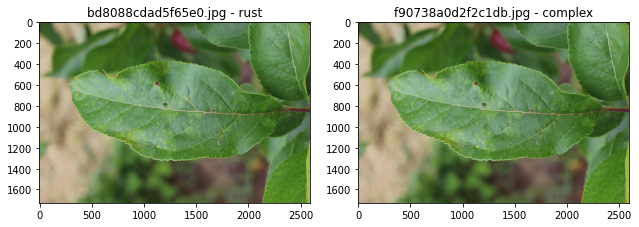

In [ ]:
plot_duplicates('ec8e62e066338b14b1bb6ad3e799a66b')

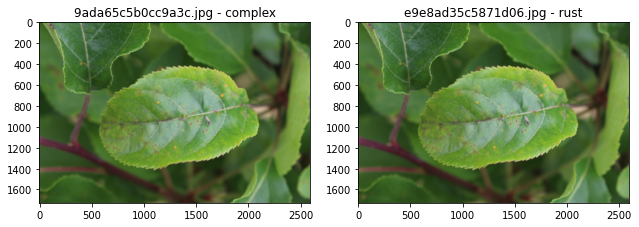

In [ ]:
plot_duplicates('61320a0a2bd07ee7d120b6688dd8f028')

Existem duplicatas com labes diferentes , verificando a quantidade de divergências

In [ ]:
def ret_diff(hash):
  df_l = df_dup[df_dup['hash'] == hash].reset_index(drop = True)
  if df_l['labels'].iloc[0] == df_l['labels'].iloc[1]:
    return 'igual'
  elif df_l['labels'].iloc[0] != df_l['labels'].iloc[1]:
    return 'diferente'



In [ ]:
df_dup['diff'] = df_dup['hash'].apply(ret_diff)
df_dup['diff'].value_counts()

diferente    54
Name: diff, dtype: int64

In [ ]:
df_dup['labels'].value_counts()

rust                       27
complex                    20
rust complex                6
rust frog_eye_leaf_spot     1
Name: labels, dtype: int64

In [ ]:
df_dup[df_dup['labels'] == 'rust frog_eye_leaf_spot']

image                   labels  ... qtd       diff
11752  d1dec0973c2cf4a1.jpg  rust frog_eye_leaf_spot  ...   2  diferente

[1 rows x 16 columns]

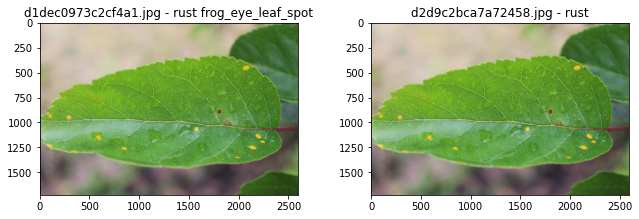

In [ ]:
plot_duplicates('c6b45c05b3b526c990ef8433a2f441a7')

## 03.03 - Análise do Tamanho

Fazer analise de tamanho para verificar qual melhor forma de resize

In [ ]:
df_test.to_csv('./drive/MyDrive/TFG-unicamp/df_test_exif.csv', index = False)
df_train.to_csv('./drive/MyDrive/TFG-unicamp/df_train_exif.csv', index = False)

# Preparação do Data Set

In [ ]:
CLASSES = np.asarray(['complex', 'frog_eye_leaf_spot', 'healthy', 'powdery_mildew', 'rust', 'scab'])
img_height = 256
img_width = 256
batch_size = 128
AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
image_count = len(list(df_train.image))

In [ ]:
def prepare(df):
  df['target'] = df.labels.map(lambda e: np.in1d(CLASSES, e.split(' ')).astype('float32'))
  return df

prepare(df_train)

In [ ]:
#Colocar de pandas df em tf dataset
#https://www.tensorflow.org/tutorials/load_data/images#using_tfdata_for_finer_control
#https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_tensor_slices

In [ ]:
def format_path(image):
    return '/content/dataset/train_images/' + image

In [ ]:
train_paths = df_train['image'].apply(format_path).values

list_ds = tf.data.Dataset.from_tensor_slices((train_paths, np.vstack(df_train['target']).astype(np.float)))

#dividir em treino e validação
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

In [ ]:
def decode_img(img):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [ ]:
def process_path(file_path, labels):
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, labels

In [ ]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

In [ ]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

In [ ]:
train_ds

<PrefetchDataset shapes: ((None, 256, 256, 3), (None, 6)), types: (tf.float32, tf.float64)>

In [ ]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

# 04 - Baseline

Vamos pegar a saída da ResNet50 após todas as convoluções, congelar os pesos, e adicionar uma camada densa treinável para as novas classes do CIFAR-10. Podemos pensar nas camadas congeladas como extrator de características.


## 01 - Baseline

In [ ]:
F1_score = tfa.metrics.F1Score(
    num_classes= len(CLASSES),
    average = 'weighted',
)

NameError: ignored

In [ ]:
#pre processar os dados, o keras espera entre -1 e 1, colcoar uma camada de pre processamento -> rescalling(escala e offset) -> kera layer preprocessing
#tentar diminuir o tamanho da imagem (128, 128)
#softmax não serve para multilabel, se um aumento a probabilidade->diminui as outras
#classificador multilabel 
#sigmoid faz classificação multilabel
#
#organização -> Setup, Dados, 


In [ ]:
#Baseline
model_baseline = Sequential()
#Camada convolucional com 32 filtros de tamanho 3x3 
model_baseline.add(Conv2D(32, 3, padding='same', activation='relu', input_shape=(256, 256, 3)))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

model_baseline.add(Conv2D(16, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

model_baseline.add(Conv2D(16, 3, padding='same', activation='relu'))
#Max pooling de tamanho 2x2
model_baseline.add(MaxPooling2D(pool_size=(2,2)))

#Operação de vetorização dos dados
model_baseline.add(Flatten())
model_baseline.add(Dense(len(CLASSES),activation='sigmoid'))

model_baseline.compile(optimizer=tf.keras.optimizers.Adam(0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[F1_score])

model_baseline.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 16)      4624      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 16)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 16)        2320      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 16)       0

In [ ]:
class InterruptingCallback(tf.keras.callbacks.Callback):
   def on_epoch_begin(self, epoch, logs=None):
     if epoch == 2:
       raise RuntimeError('Interrupting!')


In [ ]:
#!mkdir './drive/MyDrive/TFG-unicamp/temp'
backup = tf.keras.callbacks.experimental.BackupAndRestore(backup_dir="./drive/MyDrive/TFG-unicamp/temp")
#stop_callback = InterruptingCallback()

In [ ]:
drive_path = './drive/MyDrive/TFG-unicamp'
filepath = f'{drive_path}/baseline_vanilla_sem_pesos.h5'

early_stop = EarlyStopping(monitor='f1_score',patience=10)

callback_list = [backup, early_stop]

steps_per_epoch = 2000/batch_size

history_model_baseline= model_baseline.fit(train_ds,steps_per_epoch=steps_per_epoch,
                                           epochs = 64, batch_size = batch_size,                                        
                                           validation_data= val_ds,)
                                           #callbacks = callback_list)

Epoch 1/64
15/15 [==============================] - 128s 7s/step - loss: 12.7345 - f1_score: 0.2212 - val_loss: 2.4151 - val_f1_score: 0.1713
Epoch 2/64
15/15 [==============================] - 32s 2s/step - loss: 1.5052 - f1_score: 0.2220 - val_loss: 0.6590 - val_f1_score: 0.1845
Epoch 3/64
15/15 [==============================] - 36s 2s/step - loss: 0.5654 - f1_score: 0.2266 - val_loss: 0.5011 - val_f1_score: 0.1678
Epoch 4/64
15/15 [==============================] - 36s 2s/step - loss: 0.4678 - f1_score: 0.2368 - val_loss: 0.4601 - val_f1_score: 0.1914
Epoch 5/64
15/15 [==============================] - 36s 2s/step - loss: 0.4521 - f1_score: 0.2229 - val_loss: 0.4516 - val_f1_score: 0.1998
Epoch 6/64
15/15 [==============================] - 37s 2s/step - loss: 0.4439 - f1_score: 0.2407 - val_loss: 0.4479 - val_f1_score: 0.2278
Epoch 7/64
15/15 [==============================] - 28s 2s/step - loss: 0.4384 - f1_score: 0.2726 - val_loss: 0.4463 - val_f1_score: 0.2329
Epoch 8/64
15/15 [

## Resnet com imagenet

In [ ]:
# Carregamento do modelo pré-treinado SEM as camadas densas (include_top = False)
model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(256,256,3)) # 32 x 32 (?)
#model.summary()

# Congela camadas pré-treinadas
for layer in model.layers:
    layer.trainable = False

In [ ]:
# Insere novas camadas no fim da rede para classificação
frozen_model = tf.keras.Sequential([
  #tf.keras.Input(shape = (256,256,3)),
  tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1, input_shape=(img_height, img_width, 3)),
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(CLASSES), activation='sigmoid')
])

frozen_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)


# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


frozen_model.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=sgd, metrics=[F1_score])

frozen_model.fit(train_ds, epochs=100, callbacks=[early],
                  validation_data=val_ds)

Epoch 1/100
117/117 [==============================] - 40s 317ms/step - loss: 0.4431 - f1_score: 0.3074 - val_loss: 0.4471 - val_f1_score: 0.1418
Epoch 2/100
117/117 [==============================] - 36s 306ms/step - loss: 0.4363 - f1_score: 0.1661 - val_loss: 0.4379 - val_f1_score: 0.1493
Epoch 3/100
117/117 [==============================] - 36s 306ms/step - loss: 0.4335 - f1_score: 0.1830 - val_loss: 0.4366 - val_f1_score: 0.1525
Epoch 4/100
117/117 [==============================] - 36s 306ms/step - loss: 0.4316 - f1_score: 0.1953 - val_loss: 0.4355 - val_f1_score: 0.2148
Epoch 5/100
117/117 [==============================] - 36s 307ms/step - loss: 0.4295 - f1_score: 0.2051 - val_loss: 0.4275 - val_f1_score: 0.1776
Epoch 6/100
117/117 [==============================] - 36s 307ms/step - loss: 0.4284 - f1_score: 0.2105 - val_loss: 0.4267 - val_f1_score: 0.1831
Epoch 7/100
117/117 [==============================] - 36s 305ms/step - loss: 0.4272 - f1_score: 0.2168 - val_loss: 0.4322 -

KeyboardInterrupt: ignored

In [ ]:
# Insere novas camadas no fim da rede para classificação
frozen_model_without_rescaling = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(len(CLASSES), activation='sigmoid')
])

frozen_model_without_rescaling.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
# Instancia um otimizador SGD, compila e treina o modelo completo
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)


# Early Stopping
early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


frozen_model_without_rescaling.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=sgd, metrics=[F1_score])

frozen_model_without_rescaling.fit(train_ds, epochs=200, callbacks=[early],
                  validation_data=val_ds)

Epoch 1/200
117/117 [==============================] - 264s 2s/step - loss: 0.4433 - f1_score: 0.3213 - val_loss: 0.3970 - val_f1_score: 0.3908
Epoch 2/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3847 - f1_score: 0.4359 - val_loss: 0.3655 - val_f1_score: 0.5145
Epoch 3/200
117/117 [==============================] - 36s 306ms/step - loss: 0.3609 - f1_score: 0.5020 - val_loss: 0.3469 - val_f1_score: 0.5631
Epoch 4/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3457 - f1_score: 0.5412 - val_loss: 0.3345 - val_f1_score: 0.5951
Epoch 5/200
117/117 [==============================] - 36s 308ms/step - loss: 0.3352 - f1_score: 0.5665 - val_loss: 0.3249 - val_f1_score: 0.6158
Epoch 6/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3273 - f1_score: 0.5813 - val_loss: 0.3180 - val_f1_score: 0.6283
Epoch 7/200
117/117 [==============================] - 36s 305ms/step - loss: 0.3210 - f1_score: 0.5949 - val_loss: 0.3119 - v

In [ ]:
#fazer o predict e calcular por classe - ver aulas de deep learning, calcular matriz de confusão
#usar o f1 balanceado - https://www.tensorflow.org/addons/api_docs/python/tfa/metrics/F1Score - mesma coisa que acuraria e acuracia balanceada
#testar outros tipos de f1 (macro, micro)
#pesos nas classes (https://scikit-learn.org/stable/modules/generated/sklearn.utils.class_weight.compute_sample_weight.html)


# 05 - One vs All

###removendo duplicatas
Nesse caso como não somos especialistas vamos dropar qualquer coluna duplicada

In [18]:
df_test

image   labels      dataset  ... width  format  mode
0  85f8cb619c66b863.jpg  healthy  test_images  ...  3456    JPEG   RGB
1  ad8770db05586b59.jpg  healthy  test_images  ...  2672    JPEG   RGB
2  c7b03e718489f3ca.jpg  healthy  test_images  ...  2672    JPEG   RGB

[3 rows x 14 columns]

In [19]:
df_duplicadas = df_train[df_train['qtd'] == 2][['image', 'labels', 'hash', 'qtd']].sort_values('hash')
#df_val_f[['image', 'hash', 'labels']].reset_index(drop = True).to_csv('./drive/MyDrive/TFG-unicamp/data/df_val.csv', index = False)
df_duplicadas.to_csv('./drive/MyDrive/TFG-unicamp/data/df_duplicatas.csv', index = False)

In [20]:
len(df_train[df_train['qtd'] == 2][['image', 'labels', 'hash', 'qtd']])


54

In [21]:
df_test = df_test.drop_duplicates('hash', keep = False).reset_index(drop = True)
df_train = df_train.drop_duplicates('hash', keep = False).reset_index(drop = True)

## 05.01 - Colocando coluna de labels

In [22]:
df_train['labels'].value_counts().values

array([4826, 4624, 3181, 1833, 1582, 1184,  686,  200,  165,  119,   91,
         87])

In [23]:
def ret_df_count_pct(df):
  df_count_pct_labels = pd.DataFrame(df['labels'].value_counts()/len(df))
  df_count_pct_labels['count'] = df['labels'].value_counts().values
  df_count_pct_labels = df_count_pct_labels[['count', 'labels']]
  df_count_pct_labels = df_count_pct_labels.rename(columns = {'labels':'pct'})
  return df_count_pct_labels

In [24]:
df_pct_labels = ret_df_count_pct(df_train)
df_pct_labels

count       pct
scab                              4826  0.259770
healthy                           4624  0.248897
frog_eye_leaf_spot                3181  0.171224
rust                              1833  0.098665
complex                           1582  0.085154
powdery_mildew                    1184  0.063731
scab frog_eye_leaf_spot            686  0.036925
scab frog_eye_leaf_spot complex    200  0.010765
frog_eye_leaf_spot complex         165  0.008881
rust frog_eye_leaf_spot            119  0.006405
rust complex                        91  0.004898
powdery_mildew complex              87  0.004683

In [25]:
list(df_pct_labels[df_pct_labels['pct'] > 0.05]['pct'].index)

['scab', 'healthy', 'frog_eye_leaf_spot', 'rust', 'complex', 'powdery_mildew']

In [26]:
lst_main_labels = list(df_pct_labels[df_pct_labels['pct'] > 0.05]['pct'].index)

In [27]:
for main_label in lst_main_labels:
  print(main_label)
  df_train['{}'.format(main_label)] = df_train['labels'].str.contains('{}'.format(main_label))
  df_train['{}'.format(main_label)] = df_train['{}'.format(main_label)].astype(int)
  
  df_test['{}'.format(main_label)] = df_test['labels'].str.contains('{}'.format(main_label))
  df_test['{}'.format(main_label)] = df_test['{}'.format(main_label)].astype(int)
  

scab
healthy
frog_eye_leaf_spot
rust
complex
powdery_mildew


## 05.02 - Separando em treino teste e validação

In [28]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

In [29]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)

In [30]:
X = df_train.drop('labels', axis = 1)
y = df_train['labels']

In [31]:
sss.get_n_splits(X,y)

1

In [32]:
for train_index, val_index in sss.split(X,y):
  X_train, X_val = X.loc[train_index], X.loc[val_index]
  y_train, y_val = y.loc[train_index], y.loc[val_index]


### 05.02.03 -  df_train_f

In [33]:
df_train_f = X_train.copy()
df_train_f['labels'] = y_train

In [34]:
ret_df_count_pct(df_train_f)

count       pct
scab                              3861  0.259790
healthy                           3699  0.248890
frog_eye_leaf_spot                2545  0.171242
rust                              1466  0.098641
complex                           1265  0.085116
powdery_mildew                     947  0.063720
scab frog_eye_leaf_spot            549  0.036940
scab frog_eye_leaf_spot complex    160  0.010766
frog_eye_leaf_spot complex         132  0.008882
rust frog_eye_leaf_spot             95  0.006392
rust complex                        73  0.004912
powdery_mildew complex              70  0.004710

In [35]:
df_train_f

image  ...                           labels
8370   bc371e934091cd67.jpg  ...  scab frog_eye_leaf_spot complex
9961   c521af133986bfc8.jpg  ...               frog_eye_leaf_spot
13461  df12622e774c8999.jpg  ...                          healthy
5007   a763bf621d544718.jpg  ...                          complex
7192   b43fd252078b2e1d.jpg  ...                          healthy
...                     ...  ...                              ...
835    85b575cdcb636848.jpg  ...               frog_eye_leaf_spot
214    8181321fe6f2cf27.jpg  ...               frog_eye_leaf_spot
10524  c8ed3091d97563f0.jpg  ...               frog_eye_leaf_spot
15671  ef94d4d6da524a28.jpg  ...                             rust
17650  fb3ff1824d4d4421.jpg  ...                          healthy

[14862 rows x 21 columns]

### 05.02.01 - df_val_f


#### **DataFrame**

In [36]:
df_val_f = X_val.copy()
df_val_f['labels'] = y_val

In [37]:
ret_df_count_pct(df_val_f)

count       pct
scab                               965  0.259688
healthy                            925  0.248924
frog_eye_leaf_spot                 636  0.171152
rust                               367  0.098762
complex                            317  0.085307
powdery_mildew                     237  0.063778
scab frog_eye_leaf_spot            137  0.036868
scab frog_eye_leaf_spot complex     40  0.010764
frog_eye_leaf_spot complex          33  0.008881
rust frog_eye_leaf_spot             24  0.006459
rust complex                        18  0.004844
powdery_mildew complex              17  0.004575

#### **DataSet**

In [38]:
def crop_leaf(img):
    #img=ret_img(img_name, TRAIN_PATH)
    #emb_img = img.copy()
    edges = cv2.Canny(img, 100, 200)
    edge_coors = []
    for i in range(edges.shape[0]):
        for j in range(edges.shape[1]):
            if edges[i][j] != 0:
                edge_coors.append((i, j))
    row = np.argsort([coor[0] for coor in edge_coors])
    col = np.argsort([coor[1] for coor in edge_coors])
    row_min = edge_coors[row[0]][0]
    row_max = edge_coors[row[-1]][0]
    col_min = edge_coors[col[0]][1]
    col_max = edge_coors[col[-1]][1]
    new_img = img[row_min:row_max, col_min:col_max]
    

    return new_img

In [39]:
AUTOTUNE = tf.data.AUTOTUNE
HEIGHT_CROP = int(0.6* df_train_f['height'].mean())
WIDTH_CROP = int(0.6* df_train_f['width'].mean())

HEIGHT = 224
WIDTH = 224
SEED = 42
BATCH_SIZE= 64

def format_path(image):
    return '/content/dataset/train_images/' + image

def get_label(file_path):
  # Convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)


def decode_img(img, resize = False):
  # Convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # Resize the image to the desired size
  return img

def process_path(file_path, label):

  #label = get_label(file_path)
  # Load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label


#centercrop <<< ARRUMAR
center_crop = tf.keras.Sequential([
  tf.keras.layers.CenterCrop(height = HEIGHT_CROP , width = WIDTH_CROP)
])

#data_augmentation 
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal_and_vertical"),
  tf.keras.layers.RandomRotation(0.1)
])
 

# Resize
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(HEIGHT, WIDTH)#,
  #layers.Rescaling(1./255)   #after
])


def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(BATCH_SIZE)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds


    
def ret_tf_ds_df (df,label ,crop_leaf_b = False, augmentation = False):
  
  train_path = df['image'].apply(format_path).values
  # create_dataset  
  tf_ds = tf.data.Dataset.from_tensor_slices((train_path, np.vstack(df[label])))
  #mapping img
  tf_ds = tf_ds.map(process_path, num_parallel_calls = AUTOTUNE)
  
  #center crop <<< NAO ESTA FUNCIONANDO
  if crop_leaf_b == True:
    tf_ds = tf_ds.map(lambda x, y :(crop_leaf(x), y))

  #augmentation
  if augmentation == True:
    tf_ds = tf_ds.map(lambda x, y :(data_augmentation(x), y))

  #resize
  tf_ds = tf_ds.map(lambda x, y :(resize_and_rescale(x), y))


  #performance
  tf_ds = configure_for_performance(tf_ds)

  return tf_ds

In [40]:
df_val_f

image  ...                   labels
6034   acadb5623c6ae852.jpg  ...  scab frog_eye_leaf_spot
6594   af919196dac81aad.jpg  ...                     scab
8859   bf558341cda1e592.jpg  ...                  complex
17902  fccad4cb40fd8185.jpg  ...                  healthy
13431  dede8434053bb2c9.jpg  ...       frog_eye_leaf_spot
...                     ...  ...                      ...
14462  e5a4cf6d9436b380.jpg  ...       frog_eye_leaf_spot
6857   b0eb838a947afc94.jpg  ...                     scab
17703  fbd7c2c55288983a.jpg  ...                  healthy
13462  df1b49c511ebb105.jpg  ...                  healthy
1108   87f2de8415cd6386.jpg  ...           powdery_mildew

[3716 rows x 21 columns]

## 05.03 - Scab

In [41]:
def ret_label(label_bol, label_search):
  if label_bol == 0:
    return 'not {}'.format(label_search)
  else:
    return label_search

def ret_df_label(label):
  df_train_label_1 = df_train_f[df_train_f[label] == 1]
  df_train_label_0 = df_train_f[df_train_f[label] == 0].sample(len(df_train_label_1))
  df_label = pd.concat([df_train_label_1, df_train_label_0])
  df_label['y_label'] = df_label[label].apply(ret_label, label_search = label)
  
  return df_label

def ret_df_val(label):
  df_label_val = df_val_f.copy()
  df_label_val['y_label'] = df_val_f[label].apply(ret_label, label_search = label)
  return df_label_val

def plot_4_batch_img(lst_img, np_array):
  plt.figure(figsize=(9,4))

  plt.subplot(141)
  n = lst_img[0]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))
  plt.subplot(142)
  n = lst_img[1]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))
  plt.subplot(143)
  n = lst_img[2]
  plt.imshow(np_array[n] )
  plt.title('index = {}'.format(n))
  plt.subplot(144)
  n = lst_img[3]
  plt.imshow(np_array[n])
  plt.title('index = {}'.format(n))

  plt.tight_layout()

### 05.03.01 - Criação Dataframe treino e val

In [42]:
df_scab_train = ret_df_label('scab')
df_scab_val = ret_df_val('scab')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_scab_train = df_scab_train.sample(frac=1).reset_index(drop = True)
df_scab_train

image       dataset  ...                   labels   y_label
0     bdb1d2db8b1b0c48.jpg  train_images  ...                  healthy  not scab
1     98f4ab9c8ea8dc2c.jpg  train_images  ...       frog_eye_leaf_spot  not scab
2     e0e82fdd173d4017.jpg  train_images  ...                     scab      scab
3     f8898f133e1ec0ce.jpg  train_images  ...  scab frog_eye_leaf_spot      scab
4     e592305f3be935c0.jpg  train_images  ...       frog_eye_leaf_spot  not scab
...                    ...           ...  ...                      ...       ...
9135  c1bd4bb8cb6236c1.jpg  train_images  ...                     scab      scab
9136  f096d4decf456830.jpg  train_images  ...       frog_eye_leaf_spot  not scab
9137  ec97a9cb3d8b8112.jpg  train_images  ...       frog_eye_leaf_spot  not scab
9138  f093f6605fa108bd.jpg  train_images  ...       frog_eye_leaf_spot  not scab
9139  e1b85c798c679067.jpg  train_images  ...                     scab      scab

[9140 rows x 22 columns]

In [43]:
df_scab_val['y_label'].value_counts()

not scab    2574
scab        1142
Name: y_label, dtype: int64

In [44]:
ret_df_count_pct(df_scab_train)

count       pct
scab                              3861  0.422429
healthy                           1652  0.180744
frog_eye_leaf_spot                1114  0.121882
rust                               645  0.070569
complex                            565  0.061816
scab frog_eye_leaf_spot            549  0.060066
powdery_mildew                     417  0.045624
scab frog_eye_leaf_spot complex    160  0.017505
frog_eye_leaf_spot complex          58  0.006346
rust frog_eye_leaf_spot             47  0.005142
rust complex                        42  0.004595
powdery_mildew complex              30  0.003282

### 05.03.02 - Preparação dos dados

In [45]:
df_scab_train

image       dataset  ...                   labels   y_label
0     bdb1d2db8b1b0c48.jpg  train_images  ...                  healthy  not scab
1     98f4ab9c8ea8dc2c.jpg  train_images  ...       frog_eye_leaf_spot  not scab
2     e0e82fdd173d4017.jpg  train_images  ...                     scab      scab
3     f8898f133e1ec0ce.jpg  train_images  ...  scab frog_eye_leaf_spot      scab
4     e592305f3be935c0.jpg  train_images  ...       frog_eye_leaf_spot  not scab
...                    ...           ...  ...                      ...       ...
9135  c1bd4bb8cb6236c1.jpg  train_images  ...                     scab      scab
9136  f096d4decf456830.jpg  train_images  ...       frog_eye_leaf_spot  not scab
9137  ec97a9cb3d8b8112.jpg  train_images  ...       frog_eye_leaf_spot  not scab
9138  f093f6605fa108bd.jpg  train_images  ...       frog_eye_leaf_spot  not scab
9139  e1b85c798c679067.jpg  train_images  ...                     scab      scab

[9140 rows x 22 columns]

In [ ]:
https://www.tensorflow.org/tutorials/images/data_augmentation
https://keras.io/guides/preprocessing_layers/
https://keras.io/api/layers/preprocessing_layers/image_augmentation/random_zoom/#randomzoom-class

In [46]:
tf_ds_scab_train = ret_tf_ds_df(df_scab_train, 'scab')
tf_ds_scab_val = ret_tf_ds_df(df_scab_val, 'scab')

### 05.03.03 - Modelagem

In [47]:
sgd = tf.keras.optimizers.SGD(learning_rate=0.001, momentum=0.9, decay=0.001, nesterov=True)
drive_path = './drive/MyDrive/TFG-unicamp/Modelos'

def return_model(model_name):
  if model_name == 'skw':
    model = Sequential()
    # 1- set
    # CONV 
    model.add(Conv2D(filters=32, kernel_size=(3,3),input_shape=(224, 224, 3),padding='same' ,activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 2- set
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=64, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 3 - set

    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=128, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 4 - set bottleneck

    model.add(Conv2D(filters=64, kernel_size=(1,1),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # CONV 
    model.add(Conv2D(filters=32, kernel_size=(3,3),padding='same', activation='relu',))
    # NORM
    model.add(BatchNormalization())
    # POOLING LAYER
    model.add(MaxPool2D(pool_size=(2, 2)))

    # 4- FC
    model.add(Flatten())
    #sem sentido esse dropout
    model.add(Dropout(0.2))
    # DENSE 01
    model.add(Dense(1024, activation='relu'))

    model.add(Dropout(0.2))
    # DENSE 02
    model.add(Dense(1, activation='sigmoid'))


    model.compile(optimizer=tf.keras.optimizers.Adam(0.001),
                    loss=tf.keras.losses.BinaryCrossentropy(),
                    metrics=['accuracy'])
    model.summary()
    

  elif model_name == 'mobileV2':
    model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3))
    model.summary()

    # Congela camadas pré-treinadas
    for layer in model.layers:
        layer.trainable = False

    # Insere novas camadas no fim da rede para classificação
    model = tf.keras.Sequential([
      model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        #optimizer=tf.keras.optimizers.Adam(0.001), 
                        optimizer = sgd,
                        metrics=['accuracy'])

    model.summary()

  elif model_name == 'vgg16':
    model = tf.keras.applications.VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3))
    model.summary()

    # Congela camadas pré-treinadas
    for layer in model.layers:
        layer.trainable = False

    # Insere novas camadas no fim da rede para classificação
    model = tf.keras.Sequential([
      model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        #optimizer=tf.keras.optimizers.Adam(0.001), 
                        optimizer = sgd,
                        metrics=['accuracy'])
    model.summary()
    
  elif model_name == 'inceptionV3':
      
    model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(224,224,3))
    model.summary()

    # Congela camadas pré-treinadas
    for layer in model.layers:
        layer.trainable = False

    # Insere novas camadas no fim da rede para classificação
    model = tf.keras.Sequential([
      model,
      tf.keras.layers.GlobalAveragePooling2D(),
      tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                        #optimizer=tf.keras.optimizers.Adam(0.001), 
                        optimizer = sgd,
                        metrics=['accuracy'])
    model.summary()
    



  return model

#model_mobile


def ret_history_train_model(model,model_name, train_generator, val_generator, epochs = 64,  load_weights = False):
  filepath = f'{drive_path}/{model_name}.h5'

  if load_weights == True:
    model.load_weights(filepath)

  checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
  early_stop = EarlyStopping(monitor='val_accuracy',patience=20)


  callback_list = [checkpoint, early_stop]


  #num_samples /batch_size
  
  #steps_per_epoch = 32



  model_history= model.fit(train_generator,steps_per_epoch= None,
                                            epochs = epochs, batch_size = BATCH_SIZE,                                        
                                            validation_data= val_generator,
                                            callbacks = callback_list)
  return model_history, model     


In [200]:
model_skw = return_model('skw')
model_mobile = return_model('mobileV2')

Model: "sequential_27"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_16 (Conv2D)          (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_16 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 conv2d_17 (Conv2D)          (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_17 (Bat  (None, 224, 224, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                     

#### 05.03.03.01 - Baseline

In [56]:
model_skw = return_model('skw')
history_skw_scab, model_skw_scap = ret_history_train_model(model_skw, 'model_skw_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                      

#### 05.03.03.02 - MobileNet_V2


In [ ]:
model_mobile = return_model('mobileV2')
history_mobile_scab, model_mobile_scap = ret_history_train_model(model_mobile, 'model_mobileV2_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

#### 05.03.03.03 - VGG16

In [ ]:
model_vgg = return_model('vgg16')
history_vgg_scab, model_vgg_scap = ret_history_train_model(model_vgg, 'model_vgg16_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

#### 05.03.03.02 - Inception_V3

In [ ]:
model_inception = return_model('inceptionV3')
history_inception_scab, model_inception_scap = ret_history_train_model(model_inception, 'model_inception_scab', tf_ds_scab_train,tf_ds_scab_val, load_weights= False )

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_102 (Conv2D)            (None, 111, 111, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_102 (Batch  (None, 111, 111, 32  96         ['conv2d_102[0][0]']             
 Normalization)                 )                                                      

### 05.03.04 - Predições

In [ ]:
model_skw.load_weights(f'{drive_path}/model_skw_scab.h5')


In [48]:
def ret_df_predicts(ts_dataset_to_predict,model_skw_name,model_mobile_name, model_vgg_name, model_inception_name):
  #model_skw_name = 'model_skw_scab'
  #model_mobile_name = 'model_mobileV2_scab'
  #model_vgg_name = 'model_vgg16_scab'
  #model_inception_name = 'model_inception_scab'

  model_skw.load_weights(f'{drive_path}/{model_skw_name}.h5')
  model_mobile.load_weights(f'{drive_path}/{model_mobile_name}.h5')
  model_vgg.load_weights(f'{drive_path}/{model_vgg_name}.h5')
  model_inception.load_weights(f'{drive_path}/{model_inception_name}.h5')


  skd_predicts = model_skw.predict(ts_dataset_to_predict)
  mobile_predicts = model_mobile.predict(ts_dataset_to_predict)
  vgg_predicts = model_vgg.predict(ts_dataset_to_predict)
  inception_predicts= model_inception.predict(ts_dataset_to_predict)

  df_predicts = pd.DataFrame({model_skw_name:skd_predicts.ravel(),
                              model_mobile_name:mobile_predicts.ravel(),
                              model_vgg_name:vgg_predicts.ravel(),
                              model_inception_name : inception_predicts.ravel()
                              } )
  return df_predicts

In [ ]:
df_scab_predicts = ret_df_predicts(tf_ds_scab_val, 'model_skw_scab', 'model_mobileV2_scab','model_vgg16_scab', 'model_inception_scab')
df_scab_predicts['y_label'] = df_scab_val['y_label']


In [ ]:
df_scab_predicts['y_label'] = df_scab_val['y_label'].reset_index(drop=True).copy()
df_scab_predicts

model_skw_scab  model_mobileV2_scab  ...  model_inception_scab   y_label
0      6.040038e-01             0.421466  ...          8.243295e-03  not scab
1      9.861900e-01             0.360482  ...          1.514456e-05  not scab
2      1.578054e-02             0.578568  ...          6.449138e-03  not scab
3      1.224559e-09             0.584607  ...          9.999551e-01      scab
4      5.989293e-09             0.431871  ...          2.313794e-10      scab
..              ...                  ...  ...                   ...       ...
924    8.758072e-06             0.209426  ...          4.691520e-09  not scab
925    1.000000e+00             0.323293  ...          2.349753e-09  not scab
926    1.917834e-05             0.381846  ...          9.105828e-01  not scab
927    1.659291e-10             0.225220  ...          3.923235e-15  not scab
928    1.887021e-13             0.286183  ...          5.105953e-08  not scab

[929 rows x 5 columns]

In [ ]:
skd_predicts.reshape(1,-1)

array([[6.20641470e-01, 9.68191358e-08, 6.67430577e-05, 9.17334259e-01,
        6.34250231e-03, 2.30375736e-11, 1.00000000e+00, 3.24475137e-03,
        7.65393706e-05, 8.39386030e-06, 8.02533934e-04, 1.52960130e-22,
        3.43967578e-03, 9.90555704e-01, 9.99997497e-01, 1.69884151e-09,
        7.99771726e-01, 9.65426564e-01, 1.94181030e-06, 6.06478716e-05,
        1.60418931e-05, 9.99991298e-01, 1.00000000e+00, 5.63839963e-03,
        9.85554934e-01, 9.99996185e-01, 2.07534386e-03, 3.50834080e-06,
        8.73250974e-06, 1.56643455e-06, 5.58469093e-09, 9.87699270e-01,
        9.92188573e-01, 1.00000000e+00, 9.80005026e-01, 1.65087986e-03,
        1.25739491e-04, 9.62947130e-01, 1.33442532e-04, 6.66369498e-02,
        1.00000000e+00, 9.99789655e-01, 2.15398668e-08, 4.08122969e-06,
        9.19525325e-01, 1.00000000e+00, 4.06872248e-04, 9.45176726e-05,
        4.11372421e-05, 2.40582053e-16, 3.25026950e-22, 3.36369266e-11,
        4.11662586e-14, 6.87424421e-01, 4.42700554e-03, 4.262858


## 05.04 - Healthy

### 05.04.01 - Criação do DataFrame treino e Val

In [ ]:
df_healthy_train = ret_df_label('healthy')
df_healthy_val = ret_df_val('healthy')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_healthy_train = df_healthy_train.sample(frac=1).reset_index(drop = True)
#df_healthy_train

### 05.03.02 - Preparação dos Dados

In [ ]:
tf_ds_healthy_train = ret_tf_ds_df(df_healthy_train, 'healthy')
tf_ds_healthy_val = ret_tf_ds_df(df_healthy_val, 'healthy')

### 05.03.03 - Modelagem

#### 05.04.03.01 - Baseline

In [ ]:
history_skw_healthy, model_skw_healthy = ret_history_train_model(model_skw, 'model_skw_healthy', tf_ds_healthy_train,tf_ds_healthy_val, load_weights= False )

Epoch 1/64
138/138 [==============================] - ETA: 0s - loss: 0.5524 - accuracy: 0.7990
Epoch 00001: val_accuracy improved from -inf to 0.51561, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_skw_healthy.h5
138/138 [==============================] - 176s 1s/step - loss: 0.5524 - accuracy: 0.7990 - val_loss: 2.1144 - val_accuracy: 0.5156
Epoch 2/64
137/138 [============================>.] - ETA: 0s - loss: 0.1809 - accuracy: 0.9297
Epoch 00002: val_accuracy improved from 0.51561 to 0.84930, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_skw_healthy.h5
138/138 [==============================] - 22s 159ms/step - loss: 0.1813 - accuracy: 0.9297 - val_loss: 0.3411 - val_accuracy: 0.8493
Epoch 3/64
137/138 [============================>.] - ETA: 0s - loss: 0.1234 - accuracy: 0.9529
Epoch 00003: val_accuracy improved from 0.84930 to 0.88590, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_skw_healthy.h5
138/138 [==============================] - 22s 160

#### 05.04.03.02 - MobileNet_V2

In [ ]:
history_mobile_healthy, model_mobile_healthy = ret_history_train_model(model_mobile, 'model_mobileV2_healthy', tf_ds_healthy_train,tf_ds_healthy_val, load_weights= False )

Epoch 1/64
138/138 [==============================] - ETA: 0s - loss: 0.7163 - accuracy: 0.5212
Epoch 00001: val_accuracy improved from -inf to 0.50700, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_mobileV2_healthy.h5
138/138 [==============================] - 9s 67ms/step - loss: 0.7163 - accuracy: 0.5212 - val_loss: 0.7107 - val_accuracy: 0.5070
Epoch 2/64
137/138 [============================>.] - ETA: 0s - loss: 0.6975 - accuracy: 0.5395
Epoch 00002: val_accuracy improved from 0.50700 to 0.53068, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_mobileV2_healthy.h5
138/138 [==============================] - 9s 65ms/step - loss: 0.6975 - accuracy: 0.5394 - val_loss: 0.6831 - val_accuracy: 0.5307
Epoch 3/64
137/138 [============================>.] - ETA: 0s - loss: 0.6831 - accuracy: 0.5594
Epoch 00003: val_accuracy improved from 0.53068 to 0.53929, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_mobileV2_healthy.h5
138/138 [============================

#### 05.04.03.03 - VGG16

In [ ]:
history_vgg_healthy, model_vgg_healthy = ret_history_train_model(model_vgg, 'model_vgg16_healthy', tf_ds_healthy_train,tf_ds_healthy_val, load_weights= False )

Epoch 1/64
138/138 [==============================] - ETA: 0s - loss: 0.9628 - accuracy: 0.5038
Epoch 00001: val_accuracy improved from -inf to 0.64909, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_vgg16_healthy.h5
138/138 [==============================] - 20s 145ms/step - loss: 0.9628 - accuracy: 0.5038 - val_loss: 0.6866 - val_accuracy: 0.6491
Epoch 2/64
137/138 [============================>.] - ETA: 0s - loss: 0.6428 - accuracy: 0.6618
Epoch 00002: val_accuracy improved from 0.64909 to 0.73950, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_vgg16_healthy.h5
138/138 [==============================] - 19s 141ms/step - loss: 0.6429 - accuracy: 0.6620 - val_loss: 0.5222 - val_accuracy: 0.7395
Epoch 3/64
138/138 [==============================] - ETA: 0s - loss: 0.5589 - accuracy: 0.7190
Epoch 00003: val_accuracy did not improve from 0.73950
138/138 [==============================] - 18s 130ms/step - loss: 0.5589 - accuracy: 0.7190 - val_loss: 0.5658 - val_accur

#### 05.04.03.02 - Inception_V3

In [ ]:
history_inception_healthy, model_inception_healthy = ret_history_train_model(model_inception, 'model_inception_healthy', tf_ds_healthy_train,tf_ds_healthy_val, load_weights= False )

Epoch 1/64
138/138 [==============================] - ETA: 0s - loss: 3.0476 - accuracy: 0.5506
Epoch 00001: val_accuracy improved from -inf to 0.64909, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_inception_healthy.h5
138/138 [==============================] - 14s 101ms/step - loss: 3.0476 - accuracy: 0.5506 - val_loss: 1.4924 - val_accuracy: 0.6491
Epoch 2/64
137/138 [============================>.] - ETA: 0s - loss: 2.8572 - accuracy: 0.5651
Epoch 00002: val_accuracy improved from 0.64909 to 0.74596, saving model to ./drive/MyDrive/TFG-unicamp/Modelos/model_inception_healthy.h5
138/138 [==============================] - 14s 101ms/step - loss: 2.8564 - accuracy: 0.5650 - val_loss: 2.2768 - val_accuracy: 0.7460
Epoch 3/64
137/138 [============================>.] - ETA: 0s - loss: 2.7210 - accuracy: 0.5727
Epoch 00003: val_accuracy did not improve from 0.74596
138/138 [==============================] - 13s 93ms/step - loss: 2.7247 - accuracy: 0.5726 - val_loss: 1.5155 - va

## 5.05 - frog_eye_leaf_spot


### 05.05.01 - Criação do DataFrame treino e Val

In [ ]:
df_frog_eye_leaf_spot_train = ret_df_label('frog_eye_leaf_spot')
df_frog_eye_leaf_spot_val = ret_df_val('frog_eye_leaf_spot')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_frog_eye_leaf_spot_train = df_frog_eye_leaf_spot_train.sample(frac=1).reset_index(drop = True)
#df_frog_eye_leaf_spot_train

### 05.03.02 - Preparação dos dados

In [ ]:
tf_ds_frog_eye_leaf_spot_train = ret_tf_ds_df(df_frog_eye_leaf_spot_train, 'frog_eye_leaf_spot')
tf_ds_frog_eye_leaf_spot_val = ret_tf_ds_df(df_frog_eye_leaf_spot_val, 'frog_eye_leaf_spot')

### 05.03.03 - Modelagem

#### 05.05.03.01 - Baseline


In [ ]:
model_skw = return_model('skw')
history_skw_frog_eye_leaf_spot, model_skw_frog_eye_leaf_spot = ret_history_train_model(model_skw, 'model_skw_frog_eye_leaf_spot', tf_ds_frog_eye_leaf_spot_train,tf_ds_frog_eye_leaf_spot_val, load_weights= False )


Model: "sequential_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_494 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_494 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_495 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_495 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_32 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                     

#### 05.05.03.02 - MobileNet_V2


In [ ]:
model_mobile = return_model('mobileV2')
history_mobile_frog_eye_leaf_spot, model_mobile_frog_eye_leaf_spot = ret_history_train_model(model_mobile, 'model_mobileV2_frog_eye_leaf_spot', tf_ds_frog_eye_leaf_spot_train,tf_ds_frog_eye_leaf_spot_val, load_weights= False )

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_13 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_13[0][0]']               
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

#### 05.05.03.03 - VGG16


In [ ]:
model_vgg = return_model('vgg16')
history_vgg_frog_eye_leaf_spot, model_vgg_frog_eye_leaf_spot = ret_history_train_model(model_vgg, 'model_vgg16_frog_eye_leaf_spot', tf_ds_frog_eye_leaf_spot_train,tf_ds_frog_eye_leaf_spot_val, load_weights= False )


Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 05.05.03.02 - Inception_V3

In [ ]:
model_inception = return_model('inceptionV3')
history_inception_frog_eye_leaf_spot, model_inception_frog_eye_leaf_spot = ret_history_train_model(model_inception, 'model_inception_frog_eye_leaf_spot', tf_ds_frog_eye_leaf_spot_train,tf_ds_frog_eye_leaf_spot_val, load_weights= False )

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_11 (InputLayer)          [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_400 (Conv2D)            (None, 111, 111, 32  864         ['input_11[0][0]']               
                                )                                                                 
                                                                                                  
 batch_normalization_400 (Batch  (None, 111, 111, 32  96         ['conv2d_400[0][0]']             
 Normalization)                 )                                                      

## 05.06 - rust 	

### 05.05.01 - Criação do DataFrame treino e Val

In [73]:
df_rust_train = ret_df_label('rust')
df_rust_val = ret_df_val('rust')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_rust_train = df_rust_train.sample(frac=1).reset_index(drop = True)
#df_rust_train

###05.03.02 - Preparação dos dados

In [74]:
tf_ds_rust_train = ret_tf_ds_df(df_rust_train, 'rust')
tf_ds_rust_val = ret_tf_ds_df(df_rust_val, 'rust')

### 05.06.03 - Modelagem

#### 05.06.03.01 - Baseline


In [76]:
model_skw = return_model('skw')
history_skw_rust, model_skw_rust = ret_history_train_model(model_skw, 'model_skw_rust', tf_ds_rust_train,tf_ds_rust_val, load_weights= False )


Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_134 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_134 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_135 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_135 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_24 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                     

#### 05.06.03.02 - MobileNet_V2


In [77]:
model_mobile = return_model('mobileV2')
history_mobile_rust, model_mobile_rust = ret_history_train_model(model_mobile, 'model_mobileV2_rust', tf_ds_rust_train,tf_ds_rust_val, load_weights= False )


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

#### 05.06.03.03 - VGG16


In [49]:

model_vgg = return_model('vgg16')
history_vgg_rust, model_vgg_rust = ret_history_train_model(model_vgg, 'model_vgg16_rusty', tf_ds_complex_train,tf_ds_complex_val, load_weights= False )

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

KeyboardInterrupt: ignored

#### 05.06.03.02 - Inception_V3

In [79]:
model_inception = return_model('inceptionV3')
history_inception_rust, model_inception_rust = ret_history_train_model(model_inception, 'model_inception_rust', tf_ds_rust_train,tf_ds_rust_val, load_weights= False )

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_142 (Conv2D)            (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_142 (Batch  (None, 111, 111, 32  96         ['conv2d_142[0][0]']             
 Normalization)                 )                                                      

## 05.07 - complex


### 05.05.01 - Criação do DataFrame treino e Val

In [37]:
df_complex_train = ret_df_label('complex')
df_complex_val = ret_df_val('complex')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_complex_train = df_complex_train.sample(frac=1).reset_index(drop = True)
#df_complex_train

### 05.03.02 - Preparação dos dados

In [38]:
tf_ds_complex_train = ret_tf_ds_df(df_complex_train, 'complex')
tf_ds_complex_val = ret_tf_ds_df(df_complex_val, 'complex')

### 05.03.03 - Modelagem

#### 05.07.03.01 - Baseline


In [39]:
model_skw = return_model('skw')
history_skw_complex, model_skw_complex = ret_history_train_model(model_skw, 'model_skw_complex', tf_ds_complex_train,tf_ds_complex_val, load_weights= False )


Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_110 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_110 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_111 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_111 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 112, 112, 32)     0         
 g2D)                                                            
                                                      

#### 05.07.03.02 - MobileNet_V2


In [40]:
model_mobile = return_model('mobileV2')
history_mobile_complex, model_mobile_complex = ret_history_train_model(model_mobile, 'model_mobileV2_complex', tf_ds_complex_train,tf_ds_complex_val, load_weights= False )

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_4[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

#### 05.07.03.03 - VGG16


In [41]:
model_vgg = return_model('vgg16')
history_vgg_complex, model_vgg_complex = ret_history_train_model(model_vgg, 'model_vgg16_complex', tf_ds_complex_train,tf_ds_complex_val, load_weights= False )

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

#### 05.07.03.02 - Inception_V3

In [42]:
model_inception = return_model('inceptionV3')
history_inception_complex, model_inception_complex = ret_history_train_model(model_inception, 'model_inception_complex', tf_ds_complex_train,tf_ds_complex_val, load_weights= False )

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_118 (Conv2D)            (None, 111, 111, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_118 (Batch  (None, 111, 111, 32  96         ['conv2d_118[0][0]']             
 Normalization)                 )                                                      

## 05.08 - powdery_mildew 

### 05.08.01 - Criação do DataFrame treino e Val

In [ ]:
df_powdery_mildew_train = ret_df_label('powdery_mildew')
df_powdery_mildew_val = ret_df_val('powdery_mildew')
#df_scab_train['y_label'].value_counts()
#suffle dataframe
df_powdery_mildew_train = df_powdery_mildew_train.sample(frac=1).reset_index(drop = True)
#df_powdery_mildew_train

### 05.08.02 - Preparação dos dados

In [ ]:
tf_ds_powdery_mildew_train = ret_tf_ds_df(df_powdery_mildew_train, 'powdery_mildew')
tf_ds_powdery_mildew_val = ret_tf_ds_df(df_powdery_mildew_val, 'powdery_mildew')

### 05.08.03 - Modelagem

#### 05.08.03.01 - Baseline


In [ ]:
model_skw = return_model('skw')
history_skw_powdery_mildew, model_skw_powdery_mildew = ret_history_train_model(model_skw, 'model_skw_powdery_mildew', tf_ds_powdery_mildew_train,tf_ds_powdery_mildew_val, load_weights= False )


Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_188 (Conv2D)         (None, 224, 224, 32)      896       
                                                                 
 batch_normalization_188 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 conv2d_189 (Conv2D)         (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_189 (Ba  (None, 224, 224, 32)     128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 112, 112, 32)     0         
 2D)                                                             
                                                      

#### 05.08.03.02 - MobileNet_V2


In [ ]:
model_mobile = return_model('mobileV2')
history_mobile_powdery_mildew, model_mobile_powdery_mildew = ret_history_train_model(model_mobile, 'model_mobileV2_powdery_mildew', tf_ds_powdery_mildew_train,tf_ds_powdery_mildew_val, load_weights= False )

9420800/9406464 [==============================] - 0s 0us/step
Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_3[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                

#### 05.08.03.03 - VGG16


In [ ]:
model_vgg = return_model('vgg16')
history_vgg_powdery_mildew, model_vgg_powdery_mildew = ret_history_train_model(model_vgg, 'model_vgg16_powdery_mildew', tf_ds_powdery_mildew_train,tf_ds_powdery_mildew_val, load_weights= False )


58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

#### 05.08.03.02 - Inception_V3

In [ ]:
model_inception = return_model('inceptionV3')
history_inception_powdery_mildew, model_inception_powdery_mildew = ret_history_train_model(model_inception, 'model_inception_powdery_mildew', tf_ds_powdery_mildew_train,tf_ds_powdery_mildew_val, load_weights= False )

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_94 (Conv2D)             (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_94 (BatchN  (None, 111, 111, 32  96         ['conv2d_94[0][0]']              
 ormalization)                  )                                                      

## 05.09 - ML Model

In [77]:
def ret_df_predicts(ts_dataset_to_predict,model_skw_name,model_mobile_name, model_vgg_name, model_inception_name):
  #model_skw_name = 'model_skw_scab'
  #model_mobile_name = 'model_mobileV2_scab'
  #model_vgg_name = 'model_vgg16_scab'
  #model_inception_name = 'model_inception_scab'

  model_skw.load_weights(f'{drive_path}/{model_skw_name}.h5')
  model_mobile.load_weights(f'{drive_path}/{model_mobile_name}.h5')
  model_vgg.load_weights(f'{drive_path}/{model_vgg_name}.h5')
  model_inception.load_weights(f'{drive_path}/{model_inception_name}.h5')


  skd_predicts = model_skw.predict(ts_dataset_to_predict)
  mobile_predicts = model_mobile.predict(ts_dataset_to_predict)
  vgg_predicts = model_vgg.predict(ts_dataset_to_predict)
  inception_predicts= model_inception.predict(ts_dataset_to_predict)

  df_predicts = pd.DataFrame({model_skw_name:skd_predicts.ravel(),
                              model_mobile_name:mobile_predicts.ravel(),
                              model_vgg_name:vgg_predicts.ravel(),
                              model_inception_name : inception_predicts.ravel()
                              } )
  return df_predicts

## Train Dataset

In [50]:
df_train_f

image  ...                           labels
8370   bc371e934091cd67.jpg  ...  scab frog_eye_leaf_spot complex
9961   c521af133986bfc8.jpg  ...               frog_eye_leaf_spot
13461  df12622e774c8999.jpg  ...                          healthy
5007   a763bf621d544718.jpg  ...                          complex
7192   b43fd252078b2e1d.jpg  ...                          healthy
...                     ...  ...                              ...
835    85b575cdcb636848.jpg  ...               frog_eye_leaf_spot
214    8181321fe6f2cf27.jpg  ...               frog_eye_leaf_spot
10524  c8ed3091d97563f0.jpg  ...               frog_eye_leaf_spot
15671  ef94d4d6da524a28.jpg  ...                             rust
17650  fb3ff1824d4d4421.jpg  ...                          healthy

[14862 rows x 21 columns]

In [40]:
tf_ds_train = ret_tf_ds_df(df_train_f, 'labels')

In [51]:
model_skw = return_model('skw')
model_mobile = return_model('mobileV2')
model_vgg = return_model('vgg16')
model_inception = return_model('inceptionV3')


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 224, 224, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 224, 224, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 224, 224, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                      

In [42]:
from tqdm.notebook import tqdm
import time

In [65]:
lst_main_labels

['scab', 'healthy', 'frog_eye_leaf_spot', 'rust', 'complex', 'powdery_mildew']

In [45]:
lst_df_answers = []
for label in tqdm(list(df_pct_labels[df_pct_labels['pct'] > 0.05]['pct'].index)):
  print(label)
  
  lst_df_answers.append(ret_df_predicts(tf_ds_train, f'model_skw_{label}', f'model_mobileV2_{label}',f'model_vgg16_{label}', f'model_inception_{label}'))

  0%|          | 0/6 [00:00<?, ?it/s]

scab
healthy
frog_eye_leaf_spot
rust
complex
powdery_mildew


In [49]:
df_training_predicts = pd.concat(lst_df_answers, axis =1)
df_training_predicts['labels'] = df_train_f['labels'].reset_index(drop =True)
df_training_predicts.to_csv('./drive/MyDrive/TFG-unicamp/data/df_training_predicts.csv', index = False)

In [52]:
df_training_predicts = pd.read_csv('./drive/MyDrive/TFG-unicamp/data/df_training_predicts.csv')

In [59]:
df_train_f.shape

(14862, 21)

## Validation Dataset

In [63]:
tf_ds_val = ret_tf_ds_df(df_val_f, 'labels')

In [79]:
def ret_df_predicts_full(df_f):
  lst_main_labels = ['scab', 'healthy', 'frog_eye_leaf_spot', 'rust', 'complex', 'powdery_mildew']
  tf_ds = ret_tf_ds_df(df_f, 'labels')
  lst_df_answers = []
  for label in tqdm(lst_main_labels):
    print(label)
    
    lst_df_answers.append(ret_df_predicts(tf_ds, f'model_skw_{label}', f'model_mobileV2_{label}',f'model_vgg16_{label}', f'model_inception_{label}'))
  df_predicts = pd.concat(lst_df_answers, axis =1)
  df_predicts['labels'] = df_f['labels'].reset_index(drop =True)
  return df_predicts
  

In [81]:
df_val_predicts = ret_df_predicts_full(df_val_f)

  0%|          | 0/6 [00:00<?, ?it/s]

scab
healthy
frog_eye_leaf_spot
rust
complex
powdery_mildew


In [82]:
df_val_predicts

model_skw_scab  ...                   labels
0       2.857889e-07  ...  scab frog_eye_leaf_spot
1       1.046962e-02  ...                     scab
2       4.186235e-02  ...                  complex
3       9.793578e-01  ...                  healthy
4       4.858434e-01  ...       frog_eye_leaf_spot
...              ...  ...                      ...
3711    9.872457e-01  ...       frog_eye_leaf_spot
3712    6.090540e-01  ...                     scab
3713    1.534825e-03  ...                  healthy
3714    1.487309e-02  ...                  healthy
3715    3.040600e-01  ...           powdery_mildew

[3716 rows x 25 columns]

## Classification Model 

In [83]:
from sklearn.ensemble import RandomForestClassifier

In [84]:
rf_clf = RandomForestClassifier()

In [85]:
rf_clf.fit(df_training_predicts.drop('labels',axis =1), df_training_predicts['labels'])

RandomForestClassifier()

In [86]:
val_predicts = rf_clf.predict(df_val_predicts.drop('labels', axis =1))

In [93]:
training_predicts = rf_clf.predict(df_training_predicts.drop('labels', axis =1))

In [88]:
from sklearn.metrics import confusion_matrix, classification_report

In [89]:
cm = confusion_matrix(df_val_predicts['labels'], val_predicts)

In [94]:
print(classification_report(df_training_predicts['labels'], training_predicts))

                                 precision    recall  f1-score   support

                        complex       1.00      1.00      1.00      1265
             frog_eye_leaf_spot       1.00      1.00      1.00      2545
     frog_eye_leaf_spot complex       1.00      1.00      1.00       132
                        healthy       1.00      1.00      1.00      3699
                 powdery_mildew       1.00      1.00      1.00       947
         powdery_mildew complex       1.00      1.00      1.00        70
                           rust       1.00      1.00      1.00      1466
                   rust complex       1.00      1.00      1.00        73
        rust frog_eye_leaf_spot       1.00      1.00      1.00        95
                           scab       1.00      1.00      1.00      3861
        scab frog_eye_leaf_spot       1.00      1.00      1.00       549
scab frog_eye_leaf_spot complex       1.00      1.00      1.00       160

                       accuracy                  

In [92]:
print(classification_report(df_val_predicts['labels'], val_predicts))

                                 precision    recall  f1-score   support

                        complex       0.00      0.00      0.00       317
             frog_eye_leaf_spot       0.15      0.05      0.07       636
     frog_eye_leaf_spot complex       0.00      0.00      0.00        33
                        healthy       0.25      0.44      0.32       925
                 powdery_mildew       0.00      0.00      0.00       237
         powdery_mildew complex       0.00      0.00      0.00        17
                           rust       0.00      0.00      0.00       367
                   rust complex       0.00      0.00      0.00        18
        rust frog_eye_leaf_spot       0.00      0.00      0.00        24
                           scab       0.26      0.52      0.35       965
        scab frog_eye_leaf_spot       0.00      0.00      0.00       137
scab frog_eye_leaf_spot complex       0.00      0.00      0.00        40

                       accuracy                  

In [95]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
import time



In [96]:


from sklearn.ensemble import RandomForestRegressor

# Hyperparametros para tunning do modelo
model_tree = RandomForestRegressor()

max_depth = [1,3,5,10]
min_samples_leaf = [1,10,100,200,500]
min_weight_fraction_leaf = [0.1,0.2,0.5,0.7,0.9]
max_features = ["auto","log2","sqrt",None]
max_leaf_nodes = [None,10,20,30,40,50] 
bootstrap = [True, False]

parameters={"max_depth" :max_depth ,
           "min_samples_leaf":min_samples_leaf,
           "min_weight_fraction_leaf":min_weight_fraction_leaf,
           "max_features":max_features,
           "max_leaf_nodes":max_leaf_nodes,
           "bootstrap":bootstrap}
                
cv_folds = 5

find_tree = GridSearchCV(estimator = model_tree, param_grid = parameters, scoring = 'neg_mean_absolute_error', cv =cv_folds, n_jobs = -1, verbose = 1)
find_tree.fit(df_training_predicts.drop('labels',axis =1), df_training_predicts['labels'])
print(find_tree.best_params_)



Fitting 5 folds for each of 4800 candidates, totalling 24000 fits


ValueError: ignored